# Building a Two‑Layer Neural Network from Scratch (NumPy)


In this notebook we build a two‑layer neural network *by hand* using only NumPy. The goal is not just to get it working but to understand every moving
part.

I'm learning as I go, so expect a few side notes where I print shapes or try out different learning rates to see what happens.b
A neural network is a function with learnable weights. Our network takes an input vector $x \in \mathbb{R}^D$, transforms it through a hidden layer of $H$ units, and outputs scores for $C$ classes. Formally:

$$
\begin{aligned}
z_1 &= x W_1 + b_1 && \text{(pre-activation)} \\
h   &= \max(0, z_1) && \text{(ReLU activation)} \\
z_2 &= h W_2 + b_2 && \text{(scores)} \\
\hat{y} &= \operatorname{softmax}(z_2) && \text{(probabilities)}
\end{aligned}
$$

The training objective is the average cross‑entropy loss

$$
\mathcal{L}
= -\frac{1}{N}\sum_{i=1}^{N}\log \hat{y}_{i, y_i}
\;+\;
\frac{\lambda}{2}\left(\lVert W_1\rVert_F^2 + \lVert W_2\rVert_F^2\right).
$$

where $y_i$ is the true class label and $\lambda$ controls L2 regularisation. Because our dataset will not be linearly separable, the hidden layer will do the heavy lifting by bending the input space so that a linear classifier can succeed.



## Creating a problem that needs bending

To appreciate why we need a hidden layer, we will build a toy dataset that a linear classifier cannot solve. We take two spirals that wind around each other in the plane. For each class $j \in \{0,1\}$ we generate points by:

1. Sampling a radius $r$ that runs from 0 to 1.
2. Sampling an angle $	heta$ that sweeps a quarter turn and adding small Gaussian noise.
3. Converting from polar to Cartesian coordinates: $(x_0, x_1) = (r\sin	theta, \, r\cos	theta)$.

The resulting dataset has two interleaving arms. No single straight line can separate the classes, so we will need the hidden layer to bend the plane.


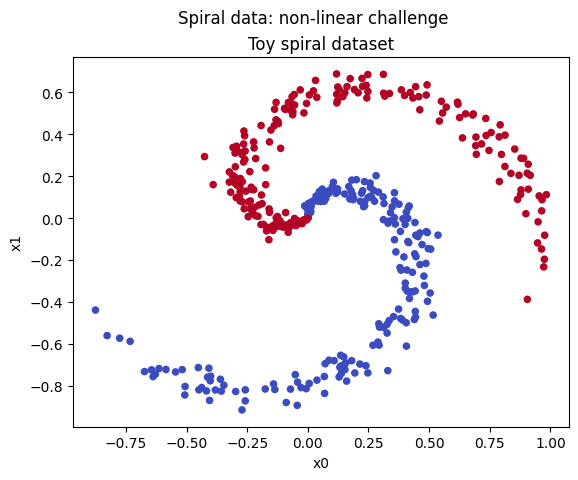

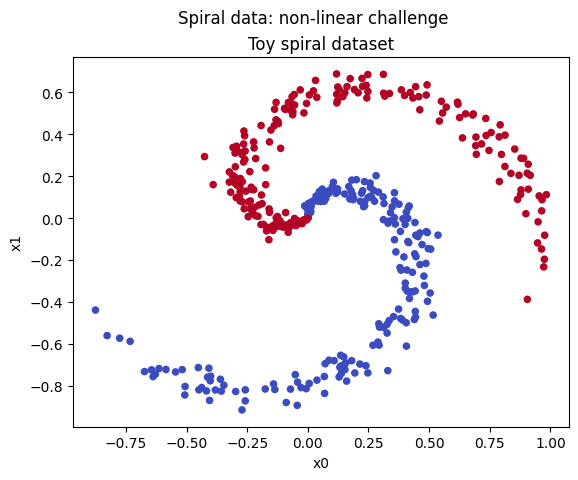

In [1]:

# imports and dataset generation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# set up data parameters
N = 200      # number of points per class
D = 2        # dimensionality of input (x0, x1)
C = 2        # number of classes

X = np.zeros((N * C, D), dtype=np.float64)
y = np.zeros(N * C, dtype=int)

rng = np.random.default_rng(seed=0)  # reproducible randomness
for j in range(C):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)                      # radius from centre
    t = np.linspace(j * 4, (j + 1) * 4, N) + rng.normal(0, 0.2, N)  # angle with noise
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]     # convert polar to Cartesian
    y[ix] = j                                       # class labels

# visualise the dataset
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_title('Toy spiral dataset')
fig.suptitle('Spiral data: non‑linear challenge')
display(fig)



## Setting up the network

We now choose the size of our hidden layer and initialise the parameters. The input dimension $D$ is 2 because each data point has two coordinates. We pick a hidden size $H$ (say, 50) and the output dimension $C$ is 2 classes.

We use the He initialisation scheme for weights: draw each element of $W_1$ from $\mathcal{N}(0, \sqrt{2/D})$ and each element of $W_2$ from $\mathcal{N}(0, \sqrt{2/H})$. This ensures that the variance of activations remains roughly constant across layers when using ReLU. Biases start at zero.


In [2]:

# initialise parameters
D_in = D
H = 50
C_out = C

params = {
    'W1': rng.normal(0.0, np.sqrt(2.0 / D_in), size=(D_in, H)),
    'b1': np.zeros(H, dtype=np.float64),
    'W2': rng.normal(0.0, np.sqrt(2.0 / H), size=(H, C_out)),
    'b2': np.zeros(C_out, dtype=np.float64)
}



## Forward pass: bending and scoring

In the forward pass we compute the activations of the hidden layer, apply the ReLU non‑linearity, compute the class scores, convert them to probabilities with softmax, and compute the cross‑entropy loss. Here's how each line works:

- **Linear transformation**: $z_1 = XW_1 + b_1$ computes the pre‑activation of the hidden layer. In code we broadcast $b_1$ across all samples.
- **ReLU non‑linearity**: $h = \max(0, z_1)$ zeroes out the negative entries of $z_1$.
- **Second linear transformation**: $z_2 = h W_2 + b_2$ produces raw scores for each class.
- **Softmax**: we subtract the maximum of each row of $z_2$ for numerical stability, exponentiate, and normalise to get probabilities.
- **Cross‑entropy loss**: for each sample we take $-\log$ of the probability assigned to the true class and average over the batch. We optionally add an L2 regularisation penalty on the weights.

An initial forward pass with random weights produces a loss close to $\log C \approx 0.693$ because the network is guessing uniformly.


In [3]:

# forward pass function
def forward(X, params, y=None, reg=0.0):
    # unpack parameters
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    # first layer affine transform
    z1 = X.dot(W1) + b1
    # ReLU activation
    h = np.maximum(0, z1)
    # second layer affine transform
    z2 = h.dot(W2) + b2
    # numerical stability: subtract row-wise max
    z2 -= z2.max(axis=1, keepdims=True)
    # softmax
    exp_scores = np.exp(z2)
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)

    cache = (X, z1, h, probs)
    # return probabilities if no labels
    if y is None:
        return probs, cache

    # compute data loss
    N_samples = X.shape[0]
    correct_logprobs = -np.log(probs[np.arange(N_samples), y])
    data_loss = correct_logprobs.mean()
    # regularisation loss
    reg_loss = 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
    loss = data_loss + reg_loss
    return loss, cache

# compute initial loss
loss, _ = forward(X, params, y, reg=0.0)
print(f"Initial loss: {loss:.4f}")


Initial loss: 0.6307


In [4]:
# Sanity check for shapes
# I'm always unsure about dimensions, so let's unpack the cache and see what each tensor looks like.
probs, cache = forward(X, params, y=None)
X_cache, z1_cache, h_cache, probs_cache = cache
print("Sanity check shapes:")
print("X:", X_cache.shape)
print("z1:", z1_cache.shape, "h:", h_cache.shape, "probs:", probs.shape)


Sanity check shapes:
X: (400, 2)
z1: (400, 50) h: (400, 50) probs: (400, 2)



## Backward pass: turning the screws

To learn, we need to know how the loss changes when we nudge each parameter. By the chain rule:

1. **Softmax + cross‑entropy**: The gradient of the loss with respect to the scores is $\frac{1}{N}\big(\hat{y} - \mathrm{one\_hot}(y)\big)$. This comes from differentiating softmax and cross‑entropy together.
2. **Second layer gradients**: We have $dW_2 = h^	op \delta$ and $db_2 = \sum_i \delta_i$, where $\delta$ is the gradient on scores and $h$ are the hidden activations. We also add $+\lambda W_2$ if we use L2 regularisation.
3. **Backpropagate into the hidden layer**: $dh = \delta W_2^	op$ transfers error from the outputs to the hidden layer.
4. **ReLU derivative**: Only units that were active during the forward pass propagate gradients: $dz_1 = dh \circ (z_1 > 0)$.
5. **First layer gradients**: $dW_1 = X^	op dz_1$ and $db_1 = \sum_i dz_{1,i}$, again adding $\lambda W_1$ for regularisation.

This sequence ensures that each parameter learns how to wiggle so as to reduce the loss: $W_2$ and $b_2$ learn how to cut the bent space, while $W_1$ and $b_1$ learn how to bend the space appropriately.


In [5]:

# backward pass function
def backward(params, cache, y, reg=0.0):
    # unpack cached values and parameters
    X, z1, h, probs = cache
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    N_samples = X.shape[0]

    # gradient on scores
    dscores = probs.copy()
    dscores[np.arange(N_samples), y] -= 1
    dscores /= N_samples

    # gradients for second layer
    dW2 = h.T @ dscores + reg * W2
    db2 = dscores.sum(axis=0)

    # backprop into hidden layer
    dh = dscores @ W2.T
    # backprop through ReLU
    dz1 = dh * (z1 > 0)

    # gradients for first layer
    dW1 = X.T @ dz1 + reg * W1
    db1 = dz1.sum(axis=0)

    return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

# compute gradients at initial parameters
loss, cache = forward(X, params, y, reg=0.0)
grads = backward(params, cache, y, reg=0.0)
print("Gradient shapes:")
for key in grads:
    print(f" {key}: {grads[key].shape}")


Gradient shapes:
 W1: (2, 50)
 b1: (50,)
 W2: (50, 2)
 b2: (2,)



## Gradient checking: a sanity check

To ensure our backprop code is correct, we compare the analytical gradients against numerical gradients computed by finite differences. For a parameter element $	heta$, the numerical derivative is:

$$
\frac{\partial \mathcal{L}}{\partial \theta}
\approx
\frac{\mathcal{L}(\theta + h) - \mathcal{L}(\theta - h)}{2h}.
$$


We perturb a handful of random elements in each parameter by a tiny amount $h$ (e.g. $10^{-5}$) and compute the loss on the perturbed parameters. The relative error between the numerical and analytical gradients should be very small (typically below $10^{-6}$).


In [6]:

# gradient checking function
def grad_check(X, y, params, reg=0.0, h=1e-5, num_checks=5, seed=42):
    # compare analytical gradients to numerical finite differences
    rng_local = np.random.default_rng(seed)
    loss, cache = forward(X, params, y, reg)
    grads = backward(params, cache, y, reg)

    for name in params:
        param = params[name]
        grad = grads[name]
        indices = rng_local.integers(0, param.size, size=num_checks)
        for idx in indices:
            old_val = param.ravel()[idx]
            # f(theta + h)
            param.ravel()[idx] = old_val + h
            loss_plus, _ = forward(X, params, y, reg)
            # f(theta - h)
            param.ravel()[idx] = old_val - h
            loss_minus, _ = forward(X, params, y, reg)
            # restore original
            param.ravel()[idx] = old_val

            grad_num = (loss_plus - loss_minus) / (2 * h)
            grad_ana = grad.ravel()[idx]
            rel_error = np.abs(grad_num - grad_ana) / max(1.0, np.abs(grad_num), np.abs(grad_ana))
            print(f"{name}[{idx}]: analytical={grad_ana:.6e}, numerical={grad_num:.6e}, rel_error={rel_error:.6e}")

# run gradient check on a few elements
print("Gradient check (a few random elements):")
grad_check(X, y, params, reg=0.0, num_checks=5)


Gradient check (a few random elements):
W1[8]: analytical=-2.281457e-04, numerical=-2.281457e-04, rel_error=3.015967e-12
W1[77]: analytical=-1.084545e-02, numerical=-1.084545e-02, rel_error=6.428188e-12
W1[65]: analytical=2.996321e-03, numerical=2.996321e-03, rel_error=3.476030e-12
W1[43]: analytical=-2.062043e-03, numerical=-2.062043e-03, rel_error=1.263470e-12
W1[43]: analytical=-2.062043e-03, numerical=-2.062043e-03, rel_error=1.263470e-12
b1[42]: analytical=-6.132968e-03, numerical=-6.132968e-03, rel_error=5.727096e-11
b1[4]: analytical=3.430327e-02, numerical=3.430327e-02, rel_error=2.508739e-10
b1[34]: analytical=-3.997491e-03, numerical=-3.997491e-03, rel_error=2.980569e-10
b1[10]: analytical=-8.601191e-03, numerical=-8.601190e-03, rel_error=1.595782e-10
b1[4]: analytical=3.430327e-02, numerical=3.430327e-02, rel_error=2.508739e-10
W2[52]: analytical=1.208778e-02, numerical=1.208778e-02, rel_error=3.222856e-13
W2[97]: analytical=5.440768e-02, numerical=5.440768e-02, rel_error=3.


## Training the network

We train the model using mini-batch stochastic gradient descent. For each epoch:

1. Shuffle the training data indices to randomise the order.
2. Loop over mini-batches of size `batch_size`.
3. For each mini-batch, compute the loss and gradients via `forward` and `backward`.
4. Update each parameter $	heta \leftarrow 	heta - \mathrm{lr} \cdot 
abla_	heta$.
5. At the end of the epoch, record the loss on the full dataset to monitor progress.

We also include L2 regularisation with coefficient `reg` to discourage large weights. The learning rate `lr` and number of epochs can be tuned. Plotting the loss over epochs allows us to see how training proceeds.


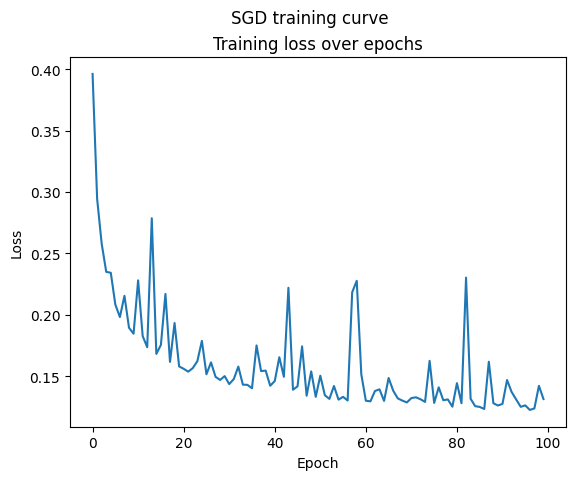

Training accuracy: 96.75%


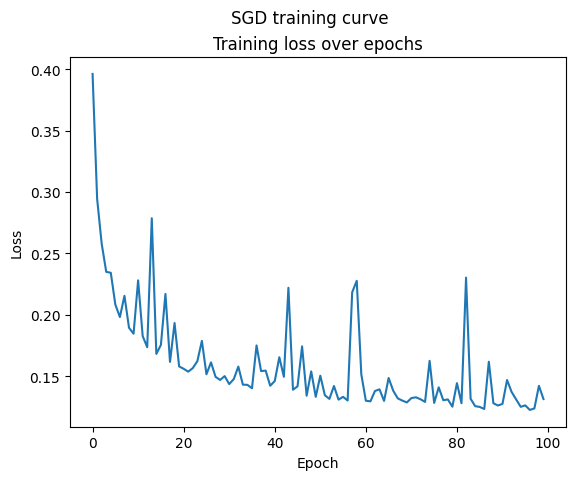

In [7]:

# training function
def train(X, y, params, reg=0.0, lr=1.0, epochs=100, batch_size=32):
    # Train the neural network using mini-batch SGD
    N_samples = X.shape[0]
    losses = []
    for epoch in range(epochs):
        indices = np.random.permutation(N_samples)
        for start in range(0, N_samples, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            # forward and backward
            loss, cache = forward(X_batch, params, y_batch, reg)
            grads = backward(params, cache, y_batch, reg)
            # update
            for name in params:
                params[name] -= lr * grads[name]
        # record full loss
        full_loss, _ = forward(X, params, y, reg)
        losses.append(full_loss)
    return losses

# train a fresh copy of parameters
params_train = {k: v.copy() for k, v in params.items()}
losses = train(X, y, params_train, reg=1e-3, lr=1.0, epochs=100, batch_size=64)

# plot training loss
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss over epochs')
fig.suptitle('SGD training curve')
display(fig)

# evaluate training accuracy
probs, _ = forward(X, params_train, y=None)
preds = np.argmax(probs, axis=1)
accuracy = (preds == y).mean()
print(f"Training accuracy: {accuracy * 100:.2f}%")
